# Generate music

To generate musical notes using a simple recurrent neural network (RNN) we will train a model using a collection of MIDI files from the [dataset](https://www.kaggle.com/datasets/kritanjalijain/music-midi-dataset/data). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.


## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [ ]:
!sudo apt -y install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
!pip install --upgrade pyfluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=15d3f9b8a3e4371fa728fefab67728c1755ed8807780f7a54996a83f0cd668ff
  Stored in directory: /root/.cache/pip/wheels/e6/9c/2b/b4b194cbb100d6f20136a22b2f76cd329b1a21139ed26c9775
Successfully built pyfluidsynth


In [ ]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=dad88560d757749404e0c1f88355696d5df6d262a1d9210d0a337dfa18c1e5bc
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the dataset containing 50 pop songs

The dataset contains about 50 MIDI files.





In [ ]:
!unzip 'midi_dataset.zip' -d 'midi_dataset'
data_dir = pathlib.Path('midi_dataset')
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Archive:  midi_dataset.zip
replace midi_dataset/midi_dataset/x (1).mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: midi_dataset/midi_dataset/x (1).mid  
  inflating: midi_dataset/midi_dataset/x (10).mid  
  inflating: midi_dataset/midi_dataset/x (11).mid  
  inflating: midi_dataset/midi_dataset/x (12).mid  
  inflating: midi_dataset/midi_dataset/x (13).mid  
  inflating: midi_dataset/midi_dataset/x (14).mid  
  inflating: midi_dataset/midi_dataset/x (15).mid  
  inflating: midi_dataset/midi_dataset/x (16).mid  
  inflating: midi_dataset/midi_dataset/x (17).mid  
  inflating: midi_dataset/midi_dataset/x (18).mid  
  inflating: midi_dataset/midi_dataset/x (19).mid  
  inflating: midi_dataset/midi_dataset/x (2).mid  
  inflating: midi_dataset/midi_dataset/x (20).mid  
  inflating: midi_dataset/midi_dataset/x (21).mid  
  inflating: midi_dataset/midi_dataset/x (22).mid  
  inflating: midi_dataset/midi_dataset/x (23).mid  
  inflating: midi_dataset/midi_dataset/x (24).mid  
  infl

## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes.


In [ ]:
sample_file = filenames[20] #give 4th file as input
print(sample_file)


midi_dataset/midi_dataset/x (17).mid


Generate a `PrettyMIDI` object for the sample MIDI file.

In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Play the sample file.

In [ ]:
import pretty_midi
import numpy as np
import soundfile as sf

def display_and_save_audio(pm: pretty_midi.PrettyMIDI, seconds=30, filename="output.wav"):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds * _SAMPLING_RATE]

    # Display the audio in notebook
    display_audio = display.Audio(waveform_short, rate=_SAMPLING_RATE)

    # Save the audio file
    sf.write(filename, waveform_short, _SAMPLING_RATE)

    return display_audio

# Example usage
# display_and_save_audio(pretty_midi_object, 30, "my_audio_file.wav")


In [ ]:
display_and_save_audio(pm)

Number instruments are used and the intrument name


In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 3
Instrument name: Lead 2 (sawtooth)


## Extract notes

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=59, note_name=B3, duration=0.2500
1: pitch=62, note_name=D4, duration=0.2500
2: pitch=55, note_name=G3, duration=0.2500
3: pitch=62, note_name=D4, duration=0.2500
4: pitch=55, note_name=G3, duration=0.2500
5: pitch=59, note_name=B3, duration=0.2500
6: pitch=69, note_name=A4, duration=0.2500
7: pitch=62, note_name=D4, duration=0.2500
8: pitch=55, note_name=G3, duration=0.2500
9: pitch=59, note_name=B3, duration=0.2500


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.


Extract the notes from the sample MIDI file.

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,59,0.0,0.25,0.0,0.25
1,62,0.0,0.25,0.0,0.25
2,55,0.0,0.25,0.0,0.25
3,62,0.5,0.75,0.5,0.25
4,55,0.5,0.75,0.0,0.25


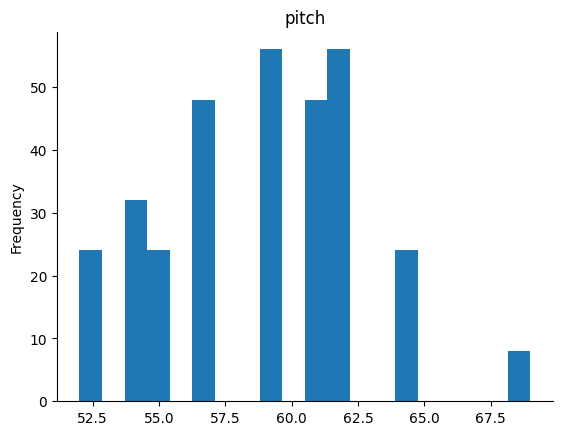

In [ ]:
# @title pitch

from matplotlib import pyplot as plt
raw_notes['pitch'].plot(kind='hist', bins=20, title='pitch')
plt.gca().spines[['top', 'right',]].set_visible(False)

It may be easier to interpret the note names rather than the pitches, so you can use the function below.
(e.g. C#4).

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['B3', 'D4', 'G3', 'D4', 'G3', 'B3', 'A4', 'D4', 'G3', 'B3'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

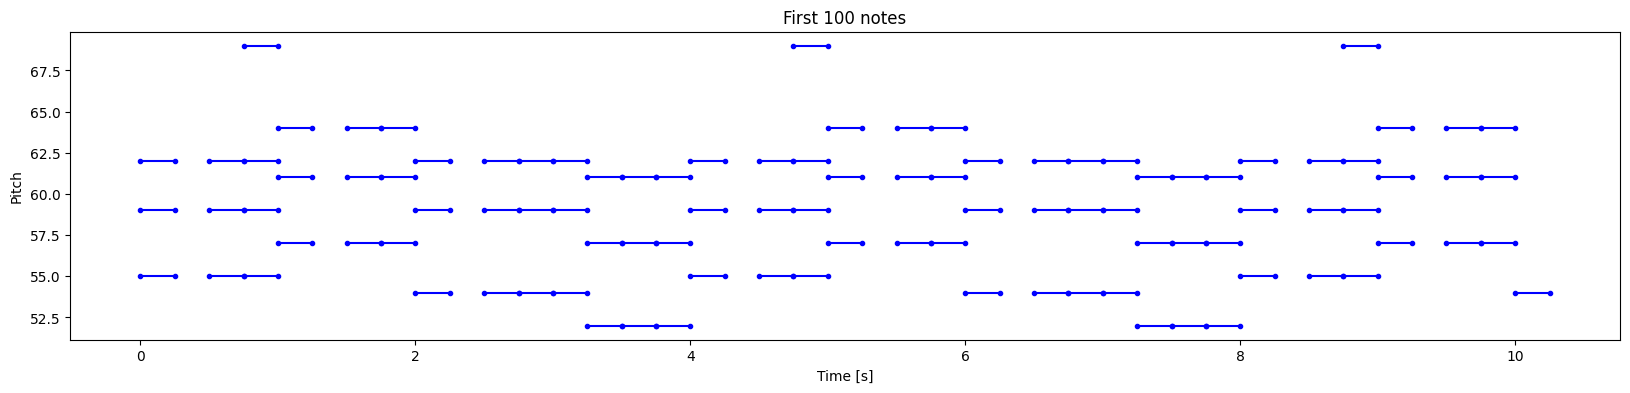

In [ ]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

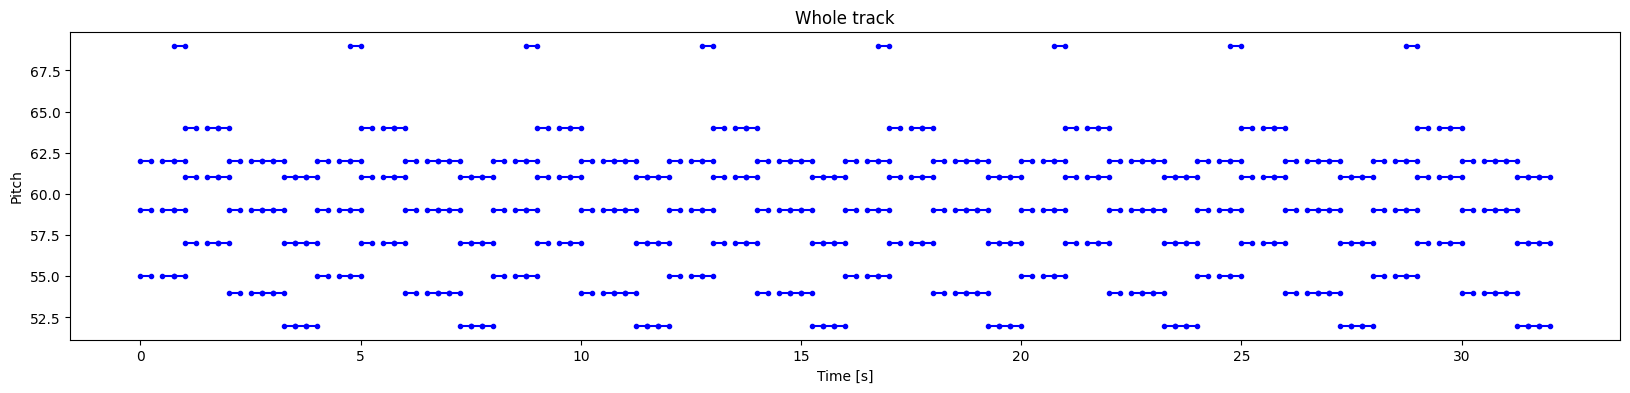

In [ ]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

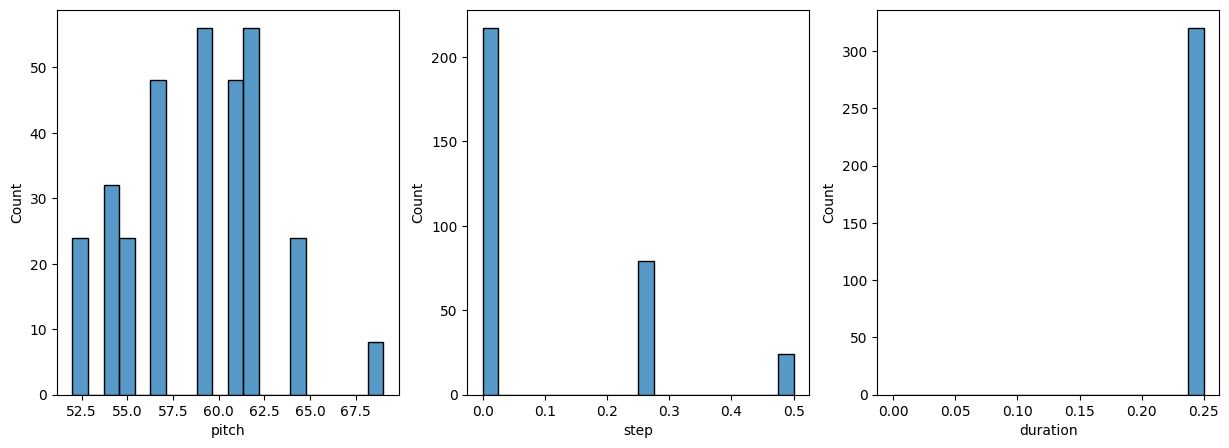

In [ ]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

Play the generated MIDI file

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files.

In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 723


Next, create a `tf.data.Dataset` from the parsed notes.

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Training the model on batches of sequences.


In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5859375 0.        0.25     ]
 [0.5859375 0.375     0.25     ]
 [0.5625    0.375     0.125    ]
 [0.546875  0.125     0.125    ]
 [0.5859375 0.125     0.125    ]
 [0.6015625 0.125     0.125    ]
 [0.6171875 0.125     0.125    ]
 [0.6015625 0.125     0.25     ]
 [0.5859375 0.625     0.25     ]
 [0.5859375 0.375     0.25     ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=72.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.125>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.125>}


configure the dataset for performance.

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │         67,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses.


In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.8619


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 5.380009174346924}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 0.5,
        'duration':8.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

Train the model.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.8860
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.3921
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3426
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.3296
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3049
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2860
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2724
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2525
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.2515
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.2456
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2396
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2335
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2256
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2292
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2239
Epoc

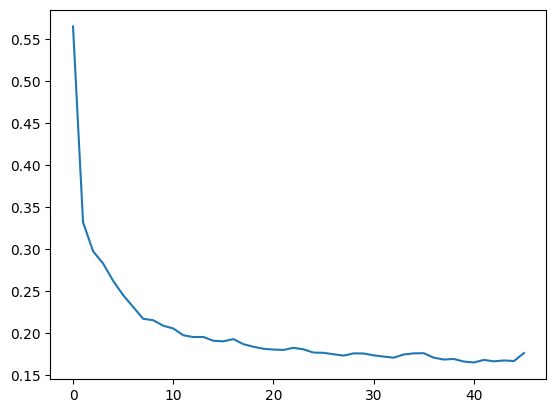

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 1.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,59,0.226006,0.246726,0.226006,0.472733
1,79,0.832343,0.714499,1.058349,1.772849
2,79,1.198398,0.977437,2.256748,3.234185
3,77,1.304695,1.026480,3.561443,4.587924
4,77,1.342095,1.032757,4.903539,5.936296
5,77,1.359174,1.025218,6.262713,7.287931
6,75,1.366243,1.014421,7.628956,8.643377
7,77,1.365938,1.004100,8.994894,9.998994
8,66,1.367723,0.994959,10.362616,11.357575
9,77,1.361839,0.988463,11.724455,12.712918


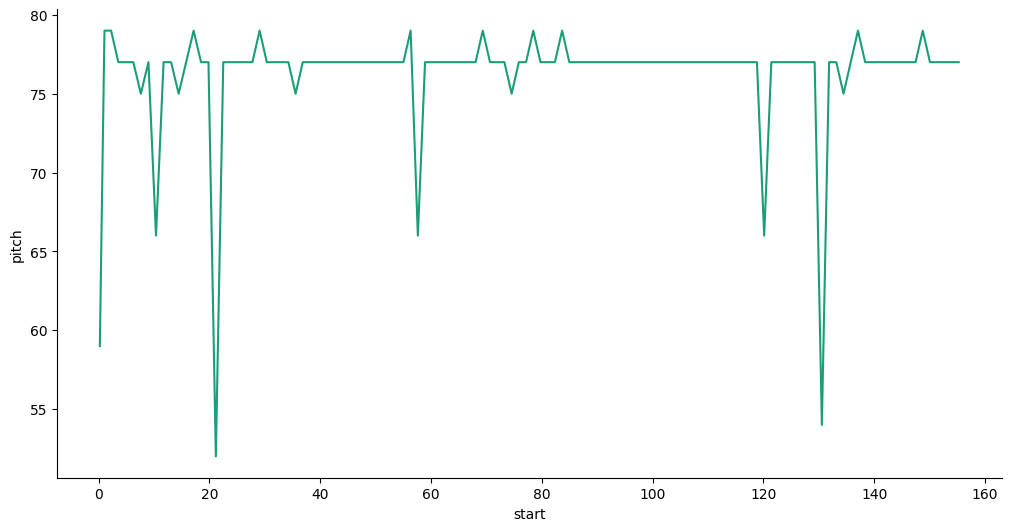

In [ ]:
# @title start vs pitch

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['start']
  ys = series['pitch']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = generated_notes.sort_values('start', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('start')
_ = plt.ylabel('pitch')

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_and_save_audio(out_pm)

In [ ]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualize the generated notes.

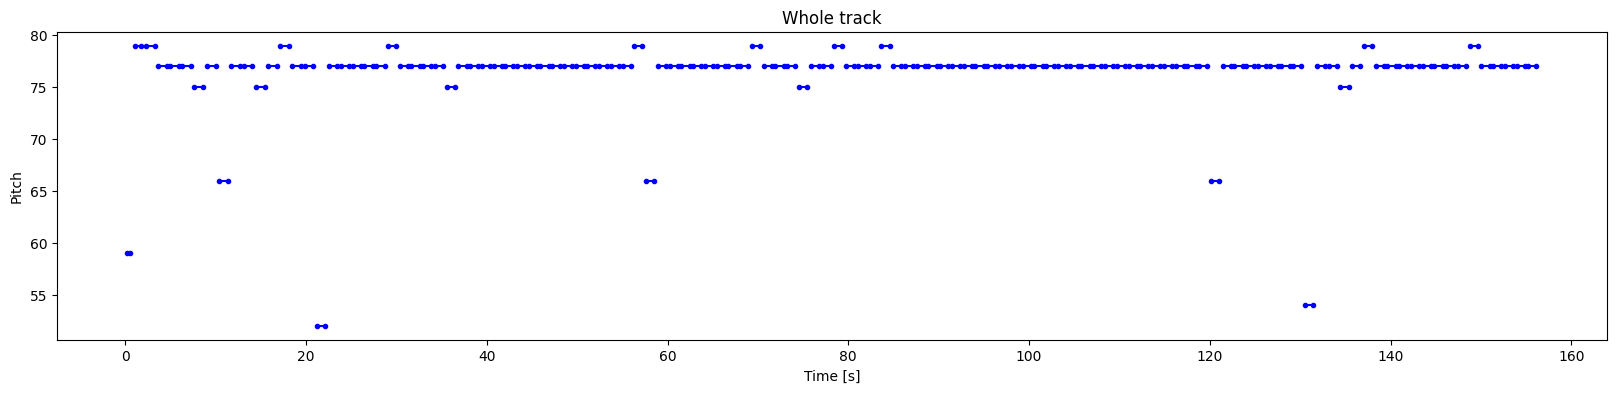

In [ ]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

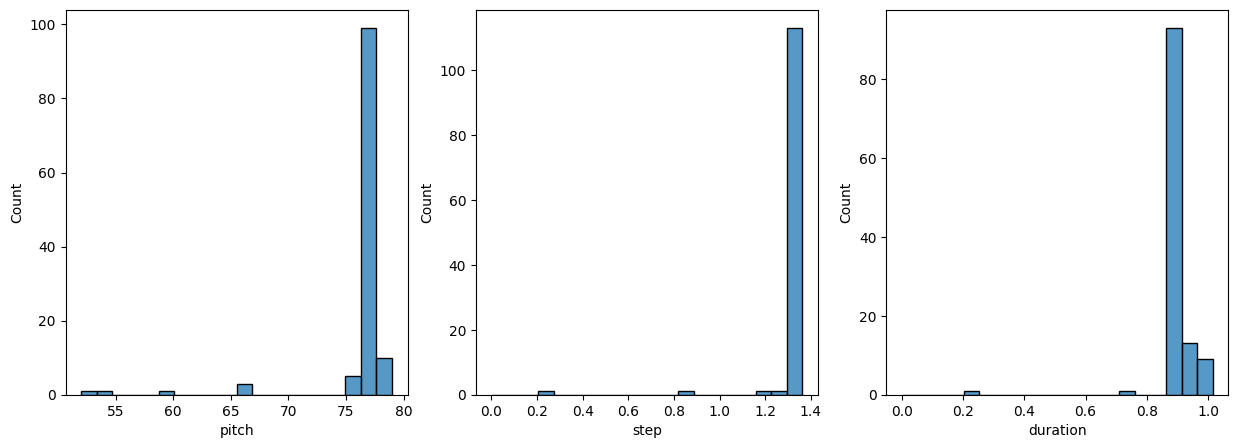

In [ ]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss.
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


In [ ]:
import pretty_midi
import numpy as np

def extract_midi_features(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    pitches = []
    durations = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitches.append(note.pitch)
            durations.append(note.end - note.start)
    return np.array(pitches), np.array(durations)

def calculate_similarity(pitches1, durations1, pitches2, durations2):
    min_len = min(len(pitches1), len(pitches2))
    pitches1 = pitches1[:min_len]
    pitches2 = pitches2[:min_len]

    min_len = min(len(durations1), len(durations2))
    durations1 = durations1[:min_len]
    durations2 = durations2[:min_len]

    pitch_similarity = np.dot(pitches1, pitches2) / (np.linalg.norm(pitches1) * np.linalg.norm(pitches2))
    duration_similarity = np.dot(durations1, durations2) / (np.linalg.norm(durations1) * np.linalg.norm(durations2))

    return (pitch_similarity + duration_similarity) / 2

user_selected_midi = 'midi_dataset/midi_dataset/x (22).mid'#fixed input
predicted_midi = 'output.mid'#output file

user_pitches, user_durations = extract_midi_features(user_selected_midi)
predicted_pitches, predicted_durations = extract_midi_features(predicted_midi)

similarity_score = calculate_similarity(user_pitches, user_durations, predicted_pitches, predicted_durations)

print(f"The similarity between the chosen song and the predicted song is: {similarity_score * 100:.2f}%")


The similarity between the chosen song and the predicted song is: 86.47%
